In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from geopy.distance import vincenty
import time

pd.set_option('display.max_columns', None)

### Read in data, and explore columns

In [2]:
air_raw = pd.read_csv('listings.csv')

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
air_raw.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19619 entries, 0 to 19618
Data columns (total 106 columns):
id                                              19619 non-null int64
listing_url                                     19619 non-null object
scrape_id                                       19619 non-null int64
last_scraped                                    19619 non-null object
name                                            19583 non-null object
summary                                         19109 non-null object
space                                           14428 non-null object
description                                     19495 non-null object
experiences_offered                             19619 non-null object
neighborhood_overview                           13220 non-null object
notes                                           8910 non-null object
transit                                         13547 non-null object
access                                          11947

### Preprocessing

We see that price is not in numeric format. Let's convert that now.

In [4]:
air_raw['price'] = air_raw['price'].replace('[\$,]', '', regex=True).astype(float)

##### Exploring the target variable "price"

The boxplot below shows that the majority of Airbnbs cost less than $350 per night.

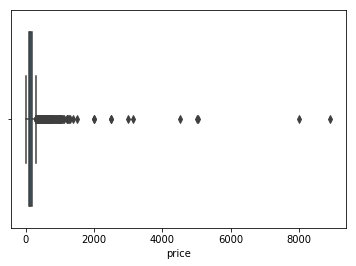

In [5]:
sns.boxplot(air_raw['price'])

Indeed, roughly 96.5% of all listings are \\$350 or less.

In [6]:
sum(air_raw['price'] <= 350)/len(air_raw)

0.965135837708344

An exploration of the more expensive listings revealed that they often have unique and novel features. See the link below for an example. Keeping these listings in the dataset would lead to overfitting. 

In [7]:
# https://www.airbnb.com/rooms/5341871

Similarly, listings that are priced unreasonably low, or at zero are likely bad data, and should be excluded from the model.

In [8]:
sum(air_raw['price'] < 20)

10

Let's remove listings less than \\$20 and greater than \\$350.

In [9]:
air_raw = air_raw[(air_raw['price'] > 19) & (air_raw['price'] < 351)]

With outliers removed, here is the distribution of price (per night).

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


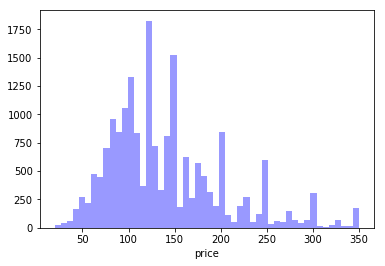

In [10]:
sns.distplot(air_raw['price'], kde=False, color='Blue')

##### Create a feature for the distance to the city center

It is generally true that Airbnb prices increase the closer you are to the city, and research reveals this is the case in Amsterdam. We therefore create a feature for the distance to the city center in miles, as the crow flies.

In [11]:
# First, create a column combining 'latitude' and 'longitude' columns.  
lat_long_list = []

for index, row in air_raw.iterrows():
    lat_long_list.append((air_raw['latitude'][index], air_raw['longitude'][index]))

air_raw['lat_long'] = lat_long_list


# Second, create a distance_to_city_center column using the new 'lat_long' column.
city_center = (52.3600, 4.8852)

distance_to_city_center_list = []

for index, row in air_raw.iterrows():
    distance_to_city_center_list.append(vincenty(city_center, air_raw['lat_long'][index]).miles)
    
air_raw['distance_to_city_center'] = distance_to_city_center_list

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  app.launch_new_instance()


### Remove text-based columns

The following columns contain textual data, and will be set aside for now. Future improvements to the model may look to these columns to extract commonalities among the words that are most associated with price movement.

In [12]:
air_raw.drop(['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit',
             'access', 'house_rules', 'xl_picture_url', 'host_about', 'interaction', 'name'],
            axis=1, inplace=True)

### Dealing with missing data

Due to the relatively small size of this dataset, columns with more than 25% of the data missing will be removed (17 columns). It is possible that the absence of data in one or more of these columns could, in and of itself be a predictor, but our initial analysis will ignore this for now.

In [13]:
# Drop columns with more than 25% nulls
for col in air_raw.columns:
    if sum(air_raw[col].isnull())/len(air_raw) > 0.25:
        air_raw.drop(col, axis=1, inplace=True)

### Exploring review-based columns

The column 'review_scores_rating' contains scores on a scale of 1-100, which gives it more variability than other scores in the data, and thus more predictive power. Other 'review_scores' columns contain scores on a scale of 1-10, and thus have less variability. See the plots below for an illustration of this.

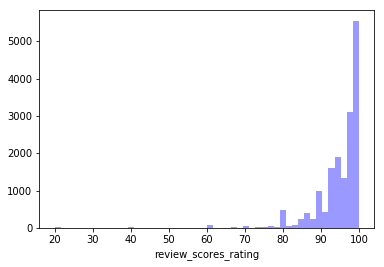

In [14]:
sns.distplot(air_raw['review_scores_rating'].dropna(), kde=False, color='Blue')

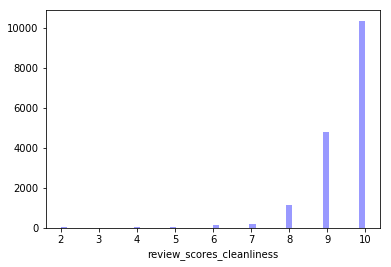

In [15]:
sns.distplot(air_raw['review_scores_cleanliness'].dropna(), kde=False, color='Blue')

About 10% of the the data in the reviews columns is missing. For now, these features will be left out of the model. At a later time it may be worth bringing them back. In order to be usable, rows with null values would either need to be dropped altogether, or the values imputed in some way. The dataset's small size suggests that the latter option is preferable. 

In [16]:
print("Null values in 'review_scores_rating': ", sum(air_raw['review_scores_rating'].isnull()))
print('Total rows: ', len(air_raw))

Null values in 'review_scores_rating':  2225
Total rows:  18925


In [17]:
air_raw.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
             'review_scores_communication', 'review_scores_location', 'review_scores_value'],
             axis=1, inplace=True)

### Remove remaining unecessary columns

The following columns were dropped for a variety of reasons: 
- Various unique identifiers
- They would not be generalizable to other cities
- They are correlated with other features 
- They are too dominant in one category (categorical and boolean columns)

In [18]:
air_raw.drop(['id', 'listing_url', 'experiences_offered', 'picture_url', 'scrape_id', 
              'last_scraped', 'host_id', 'host_url', 'host_name', 'host_location', 
              'host_thumbnail_url',  'host_picture_url', 'host_total_listings_count',
              'host_verifications', 'host_has_profile_pic', 'street', 'neighbourhood',
              'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code',
              'country', 'latitude', 'longitude', 'bed_type', 'guests_included', 
              'calendar_updated', 'has_availability', 'calendar_last_scraped',
              'requires_license', 'jurisdiction_names', 'is_business_travel_ready',
              'require_guest_profile_picture', 'require_guest_phone_verification',
              'lat_long'],
             axis=1, inplace=True
            )             

The 'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating', and 'reviews_per_month' columns were dropped due to nulls. Without imputation, they would have reduced the dataset by roughly 5,000 rows. It is recommended that these columns be a examined first when looking for additional features for the model. The first step will be determining the best way to impute missing data.

In [19]:
# drop wild card features in an effort to preserve as many rows as possible
air_raw.drop(['cleaning_fee', 'first_review', 'last_review',
             'review_scores_rating', 'reviews_per_month'], axis=1, inplace=True)

In [20]:
# drop any remaining nulls in the dataset
air_raw.dropna(inplace=True)

### Converting columns to numeric

There are several columns that should be numeric, but are classified as the datatype 'object'. Let's convert these now.

In [21]:
# convert 'extra_people' to numeric
air_raw['extra_people'] = air_raw['extra_people'].replace('[\$,]', '', regex=True).astype(float)

In [22]:
# convert 'host_since' to datetime, then convert it to int
air_raw['host_since'] = pd.to_datetime(air_raw['host_since']).dt.strftime('%Y%m%d').astype(int)

In [23]:
# convert columns from object to boolean
air_raw['host_is_superhost'] = air_raw['host_is_superhost'].astype('bool')
air_raw['host_identity_verified'] = air_raw['host_identity_verified'].astype('bool')
air_raw['is_location_exact'] = air_raw['is_location_exact'].astype('bool')
air_raw['instant_bookable'] = air_raw['instant_bookable'].astype('bool')

### Move target variable to the end

In [24]:
last_col = ['price']
air_raw = air_raw[[col for col in air_raw if col not in last_col]
                  +[col for col in last_col]]

In [25]:
air_raw.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18890 entries, 0 to 19618
Data columns (total 36 columns):
host_since                                      18890 non-null int64
host_is_superhost                               18890 non-null bool
host_listings_count                             18890 non-null float64
host_identity_verified                          18890 non-null bool
neighbourhood_cleansed                          18890 non-null object
is_location_exact                               18890 non-null bool
property_type                                   18890 non-null object
room_type                                       18890 non-null object
accommodates                                    18890 non-null int64
bathrooms                                       18890 non-null float64
bedrooms                                        18890 non-null float64
beds                                            18890 non-null float64
amenities                                       18890 n

### Machine learning and model evaluation

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score 

Let's divide the data into two DataFrames; one for categorical features, and one for numeric features. The first iteration of model testing will focus on numeric features.

In [27]:
# Divide the data into numerical and categorical columns
categoricals = air_raw[['neighbourhood_cleansed', 'property_type', 
                        'room_type', 'cancellation_policy', 'price']]

numericals = air_raw.drop(['neighbourhood_cleansed', 'property_type',
                          'room_type', 'cancellation_policy', 'amenities'],
                         axis=1)

##### Split 'numericals' into features (X) and target (y)

In [28]:
X = numericals.drop(['price'], axis=1)
y = numericals.iloc[:,-1]

##### Scale the features

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaler.fit_transform(X)

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-3.42759185,  0.        , -0.16355874, ...,  0.5398328 ,
        -0.08608409,  0.7507921 ],
       [-2.89138027,  0.        , -0.12292343, ...,  0.5398328 ,
        -0.08608409, -1.11021193],
       [-2.89565828,  0.        , -0.12292343, ..., -0.38234496,
        -0.08608409, -0.71132875],
       ...,
       [ 2.28923326,  0.        , -0.12292343, ..., -0.38234496,
        -0.08608409,  0.23951303],
       [ 2.27963383,  0.        , -0.16355874, ..., -0.38234496,
        -0.08608409, -0.02487057],
       [-0.83068548,  0.        , -0.12292343, ...,  0.5398328 ,
        -0.08608409, -1.0860356 ]])

##### Create a dataframe to store the metrics for each model
We will test mean absolute error (MAE), root mean squared error (RMSE), and R-squared. 

In [30]:
metrics = pd.DataFrame(index=['MAE', 'RMSE', 'R-squared', 'Time to Train (s)'], 
                       columns=['Linear Regression',  'Decision Tree', 'Random Forest'])

In [31]:
metrics

,Linear Regression,Decision Tree,Random Forest
MAE,NaN,NaN,NaN
RMSE,NaN,NaN,NaN
R-squared,NaN,NaN,NaN
Time to Train (s),NaN,NaN,NaN


The function below will streamline the process of training and scoring models.

In [32]:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5, iid=False):
    
    # Create the GridSearchCV objects
    if model_name in ['Linear Regression']:
        cv = estimator
    else:
        cv = GridSearchCV(estimator, param_grid, cv=cv, verbose=0, n_jobs=-1, iid=False)
        
    # Fit on the data
    t0 = time.time()
    cv.fit(X, y)
    ttt = round(time.time() - t0, 2)
    print("%s fitting takes %.2f seconds." % (model_name, ttt))
    metrics.loc['Time to Train (s)', model_name] = ttt
    
    # Predict on the test set
    predictions = cross_val_predict(cv, X, y, cv=5)
    
    # Scoring
    metrics.loc['MAE', model_name] = round(mean_absolute_error(y, predictions), 3)
    metrics.loc['RMSE', model_name] = round(np.sqrt(mean_squared_error(y, predictions)), 3)
    metrics.loc['R-squared', model_name] = round(explained_variance_score(y, predictions), 3)
    
    # Return predictions for later use in comparing with actuals
    return predictions

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate the models
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

estimators = [lr, dt, rf]

# Create param_grids for hyperparameter tuning
param_grid_lr = None
param_grid_dt = {
    'max_depth': range(5,30)
}
param_grid_rf = {
    'max_depth': range(5,30),
    'n_estimators': [10, 100]
}

param_grids = [param_grid_lr, param_grid_dt, param_grid_rf]

model_names = ['Linear Regression', 'Decision Tree', 'Random Forest']

cv_names = ['lr_cv', 'dt_cv', 'rf_cv']
cvs = [5, 5, 5]

In [34]:
lr_cv = train_and_score_model('Linear Regression', lr, param_grid_lr)

Linear Regression fitting takes 0.16 seconds.


In [35]:
dt_cv = train_and_score_model('Decision Tree', dt, param_grid_dt)

Decision Tree fitting takes 19.75 seconds.


In [36]:
rf_cv = train_and_score_model('Random Forest', rf, param_grid_rf)

Random Forest fitting takes 699.41 seconds.


In [37]:
metrics = metrics.astype(float).round(2)
metrics

,Linear Regression,Decision Tree,Random Forest
MAE,37.02,36.29,33.94
RMSE,49.46,48.45,45.40
R-squared,0.38,0.40,0.48
Time to Train (s),0.16,19.75,699.41


We will now test each model again, this time with the encoded categorical variables added as features.

In [38]:
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18890 entries, 0 to 19618
Data columns (total 5 columns):
neighbourhood_cleansed    18890 non-null object
property_type             18890 non-null object
room_type                 18890 non-null object
cancellation_policy       18890 non-null object
price                     18890 non-null float64
dtypes: float64(1), object(4)
memory usage: 885.5+ KB


In [39]:
# One-hot-encode the four categorical columns
neighbourhood_cleansed_ohe = pd.get_dummies(categoricals['neighbourhood_cleansed'])
property_type_ohe = pd.get_dummies(categoricals['property_type'])
room_type_ohe = pd.get_dummies(categoricals['room_type'])
cancellation_policy_ohe = pd.get_dummies(categoricals['cancellation_policy'])

In [40]:
# Join the "numericals" DataFrame and the encoded categorical variables
nums_and_cats = numericals.join(neighbourhood_cleansed_ohe).join(property_type_ohe).join(room_type_ohe).join(cancellation_policy_ohe)

In [41]:
# Remove property_type columns with less than 100 observations
for col in nums_and_cats:
    if sum(nums_and_cats[col]) < 100:
        nums_and_cats.drop([col], axis=1, inplace=True)

In [42]:
# Move 'price' to the end
last_col = ['price']
nums_and_cats = nums_and_cats[[col for col in nums_and_cats if col not in last_col]
                 + [col for col in last_col]]

The updated DataFrame (with categorical features added) is now ready for ML.

##### Split "nums_and_cats" into features (X) and target (y)

In [43]:
X = nums_and_cats.drop(['price'], axis=1)
y = nums_and_cats.iloc[:,-1]

##### Scale the features

In [44]:
scaler = StandardScaler()
scaler.fit(X)
scaler.fit_transform(X)

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-3.42759185,  0.        , -0.16355874, ..., -0.55790608,
        -0.77112327,  1.25721959],
       [-2.89138027,  0.        , -0.12292343, ..., -0.55790608,
        -0.77112327,  1.25721959],
       [-2.89565828,  0.        , -0.12292343, ..., -0.55790608,
        -0.77112327,  1.25721959],
       ...,
       [ 2.28923326,  0.        , -0.12292343, ...,  1.79241638,
        -0.77112327, -0.795406  ],
       [ 2.27963383,  0.        , -0.16355874, ...,  1.79241638,
        -0.77112327, -0.795406  ],
       [-0.83068548,  0.        , -0.12292343, ..., -0.55790608,
         1.29680952, -0.795406  ]])

##### Call function to train and score models

In [45]:
lr_cv = train_and_score_model('Linear Regression', lr, param_grid_lr)

Linear Regression fitting takes 0.24 seconds.


In [46]:
dt_cv = train_and_score_model('Decision Tree', dt, param_grid_dt)

Decision Tree fitting takes 26.49 seconds.


In [47]:
rf_cv = train_and_score_model('Random Forest', rf, param_grid_rf)

Random Forest fitting takes 1047.57 seconds.


In [48]:
metrics = metrics.astype(float).round(2)
metrics

,Linear Regression,Decision Tree,Random Forest
MAE,34.38,36.03,32.89
RMSE,46.40,48.15,44.42
R-squared,0.45,0.41,0.50
Time to Train (s),0.24,26.49,1047.57


We will now test each model again, creating features for individual amenities.

In [49]:
# Create the amenities columns
amenities = []

for line in air_raw['amenities'].str.split(','):
    for amenity in line:
        amenities.append(amenity)

amenities = [char.replace('{', '') for char in amenities]
amenities = [char.replace('}', '') for char in amenities]
amenities = [char.replace('"', '') for char in amenities]

amenities_unique = set(amenities)

In [50]:
len(amenities)

382365

In [51]:
len(amenities_unique)

124

Out of the 124 unique amenities, 14 were chosen as likely to be predictive of price.

In [52]:
amenities_14 = [
    'Indoor fireplace',
    'Long term stays allowed',
    'Dishwasher',
    'Washer',
    'Private entrance',
    'TV',
    'Pets allowed',
    'Hot tub',
    'Beachfront',
    'Bathtub',
    'Patio or balcony',
    'Waterfront',
    'Cable TV (or Satellite TV in US)',
    'Family/kid friendly'
]

In [53]:
# Create a list of formatted column headers
amenities_14_cols = [
    'indoor_fireplace','long_term_stays_allowed','dishwasher','washer','private_entrance',
    'tv','pets_allowed','hot_tub','beachfront','bathtub','patio_or_balcony','waterfront',
    'cable_tv','kid_friendly'
]

In [54]:
# Create the amenities DataFrame
amenities_df = pd.DataFrame()

In [55]:
# Create boolean columns for each of the 14 amenities
for amenity in amenities_14:
    amenities_df[amenity] = air_raw['amenities'].str.contains(amenity)

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# Update the column headers with the formatted names
amenities_df.columns = amenities_14_cols

In [57]:
amenities_df.head(3)

,indoor_fireplace,long_term_stays_allowed,dishwasher,washer,private_entrance,tv,pets_allowed,hot_tub,beachfront,bathtub,patio_or_balcony,waterfront,cable_tv,kid_friendly
0,False,False,False,True,True,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,True,False,False,False,False,False,False,False,False
2,True,False,False,True,False,True,False,False,False,False,False,False,False,True


Now we will join the amenities DataFrame with the numerical columns and encoded categorical columns, and assess whether this addition improves model performance.

In [58]:
nums_cats_amenities = nums_and_cats.join(amenities_df)

In [59]:
# Place target variable at the end
last_col = ['price']
nums_cats_amenities = nums_cats_amenities[[col for col in nums_cats_amenities if col not in last_col]
                                          + [col for col in last_col]]

The updated DataFrame (with the newly created amenity features) is now ready for ML.

##### Split nums_cats_amenities into features (X) and target (y)

In [60]:
X = nums_cats_amenities.drop(['price'], axis=1)
y = nums_cats_amenities.iloc[:,-1]

##### Scale the features

In [61]:
scaler = StandardScaler()
scaler.fit(X)
scaler.fit_transform(X)

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-3.42759185,  0.        , -0.16355874, ..., -0.21626226,
         0.        , -0.84636667],
       [-2.89138027,  0.        , -0.12292343, ..., -0.21626226,
         0.        , -0.84636667],
       [-2.89565828,  0.        , -0.12292343, ..., -0.21626226,
         0.        ,  1.181521  ],
       ...,
       [ 2.28923326,  0.        , -0.12292343, ..., -0.21626226,
         0.        , -0.84636667],
       [ 2.27963383,  0.        , -0.16355874, ..., -0.21626226,
         0.        , -0.84636667],
       [-0.83068548,  0.        , -0.12292343, ..., -0.21626226,
         0.        ,  1.181521  ]])

##### Call function to train and score models

In [62]:
lr_cv = train_and_score_model('Linear Regression', lr, param_grid_lr)

Linear Regression fitting takes 0.18 seconds.


In [63]:
dt_cv = train_and_score_model('Decision Tree', dt, param_grid_dt)

Decision Tree fitting takes 28.12 seconds.


In [64]:
rf_cv = train_and_score_model('Random Forest', rf, param_grid_rf)

Random Forest fitting takes 1136.19 seconds.


In [65]:
metrics

,Linear Regression,Decision Tree,Random Forest
MAE,33.757,35.930,32.723
RMSE,45.684,48.120,44.258
R-squared,0.470,0.411,0.502
Time to Train (s),0.180,28.120,1136.190


### Evaluating the individual price predictions
Individual predictions are based on the random forest model. Random forest was the most accurate of the three for both mean absolute error (MAE) and root mean squared error (RMSE).

In [66]:
print(rf_cv)

[ 84.22788724 162.74883923 216.22666667 ... 169.47200269 122.9449296
 167.91251762]


In [67]:
compare = pd.DataFrame({'actual':y, 'predictions':rf_cv, 'error':abs(y-rf_cv)})
compare.head()

,actual,predictions,error
0,59.0,84.227887,25.227887
1,80.0,162.748839,82.748839
2,125.0,216.226667,91.226667
3,150.0,115.522677,34.477323
4,65.0,85.769463,20.769463


Just over 50% of the predictions are within $30 of the actual price. More feature engineering is needed before the model can be put in production.

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


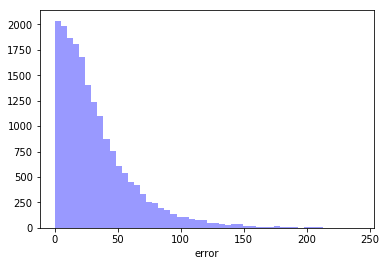

In [68]:
sns.distplot(compare['error'], kde=False, color='Blue')

In [69]:
sum(compare['error'] < 30)/len(compare)

0.584647961884595

### Feature Importances
Let's find out what the top 10 most important features are from the random forest, and the top 10 coefficients for linear regression in either direction.

In [70]:
rf.fit(X, y)

/Users/brysonsicotte/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
fi_index = []
fi_value = []
for index, value in enumerate(rf.feature_importances_):
    fi_index.append(X.columns[index])
    fi_value.append(value)
fi = pd.DataFrame(
    {'feature': fi_index,
     'importance' : fi_value
    })
fi.sort_values(by='importance', ascending=False).head(10)

,feature,importance
5,accommodates,0.255132
29,distance_to_city_center,0.112987
0,host_since,0.055777
62,Entire home/apt,0.049190
20,availability_90,0.045402
22,number_of_reviews,0.038520
9,extra_people,0.035805
21,availability_365,0.032950
7,bedrooms,0.031303
23,number_of_reviews_ltm,0.029197


Let's also get the top 10 coefficients from the linear regression model, in both the positive and negative direction.

In [72]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# Create a DataFrame with the coefficients of the linear regression model
coef_index = []
coef_value = []
for index, value in enumerate(lr.coef_):
    coef_index.append(X.columns[index])
    coef_value.append(value)

coeffs = pd.DataFrame(
    {'feature': coef_index,
     'coefficient' : coef_value
    })

In [74]:
# Get the top 10 positive coefficients
coeffs.sort_values(by='coefficient', ascending=False).head(10)

,feature,coefficient
62,Entire home/apt,76.310771
63,Private room,44.397271
39,Gaasperdam - Driemond,37.360949
41,IJburg - Zeeburgereiland,30.590906
67,indoor_fireplace,19.299585
59,Houseboat,18.516507
31,Bijlmer-Oost,15.596112
5,accommodates,15.507844
7,bedrooms,14.891070
35,Centrum-West,14.615807


In [75]:
# Get the top 10 negative coefficients
coeffs.sort_values(by='coefficient').head(10)

,feature,coefficient
29,distance_to_city_center,-19.520960
48,Slotervaart,-17.192927
53,Apartment,-15.274404
32,Bos en Lommer,-15.022482
56,Condominium,-14.006873
38,De Pijp - Rivierenbuurt,-12.788246
37,De Baarsjes - Oud-West,-12.624574
75,beachfront,-12.322881
33,Buitenveldert - Zuidas,-11.742051
47,Oud-Oost,-10.777648
